In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
crypto = "NFP"
timeframe = "15m"
df = pd.read_csv(f"data/{crypto}.csv")
df["timestamp"] = [int(datetime.timestamp(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))) for x in df["datetime"]]
df.set_index('timestamp', inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
# Extract features and target
times = df.index.astype(int) // (df.index[1] - df.index[0])
print(times)

Index([1893404, 1893405, 1893406, 1893407, 1893408, 1893409, 1893410, 1893411,
       1893412, 1893413,
       ...
       1898868, 1898869, 1898870, 1898871, 1898872, 1898873, 1898874, 1898875,
       1898876, 1898877],
      dtype='int32', name='timestamp', length=5474)


In [4]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['open', 'volume', 'high', 'low', 'close', 'hourly']
num_features = len(features)
df_scaled = scaler.fit_transform(df[features])

In [5]:
# Function to create input sequences and labels
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)


# Set the sequence length
sequence_length = 16

In [6]:
# Create sequences and labels
X, y = create_sequences(df_scaled, sequence_length)
print(X.shape)
print(y.shape)

(5458, 16, 6)
(5458, 6)


In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(num_features))

model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
# Train the model
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
171/171 [==============================] - 5s 9ms/step - loss: 0.0172
Epoch 2/20
171/171 [==============================] - 1s 8ms/step - loss: 0.0074
Epoch 3/20
171/171 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 4/20
171/171 [==============================] - 1s 9ms/step - loss: 0.0051
Epoch 5/20
171/171 [==============================] - 1s 9ms/step - loss: 0.0044
Epoch 6/20
171/171 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 7/20
171/171 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 8/20
171/171 [==============================] - 1s 8ms/step - loss: 0.0036
Epoch 9/20
171/171 [==============================] - 1s 8ms/step - loss: 0.0035
Epoch 10/20
171/171 [==============================] - 1s 9ms/step - loss: 0.0034
Epoch 11/20
171/171 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 12/20
171/171 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 13/20
171/171 [====

In [9]:
# Make predictions
y_pred = model.predict(X)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_real = scaler.inverse_transform(y)

prediction_dict = {'datetime': df["datetime"][:-sequence_length],
                   'real_price': y_real[:, 0], 'predicted_price': y_pred[:, 0]}

df_pred = pd.DataFrame.from_dict(prediction_dict)
#df_pred['datetime'] = pd.to_datetime(df['datetime'])
df_pred['datetime'] += pd.Timedelta(sequence_length // 4, unit="h")
df_pred

171/171 [==============================] - 1s 4ms/step


,datetime,real_price,predicted_price
timestamp,,,
1704063600,2024-01-01 04:00:00,0.85952,0.863155
1704064500,2024-01-01 04:15:00,0.84226,0.856968
1704065400,2024-01-01 04:30:00,0.84832,0.852317
1704066300,2024-01-01 04:45:00,0.85214,0.850736
1704067200,2024-01-01 05:00:00,0.83794,0.847926
...,...,...,...
1708971300,2024-02-26 23:15:00,0.74240,0.741574
1708972200,2024-02-26 23:30:00,0.73494,0.739687
1708973100,2024-02-26 23:45:00,0.73467,0.737277


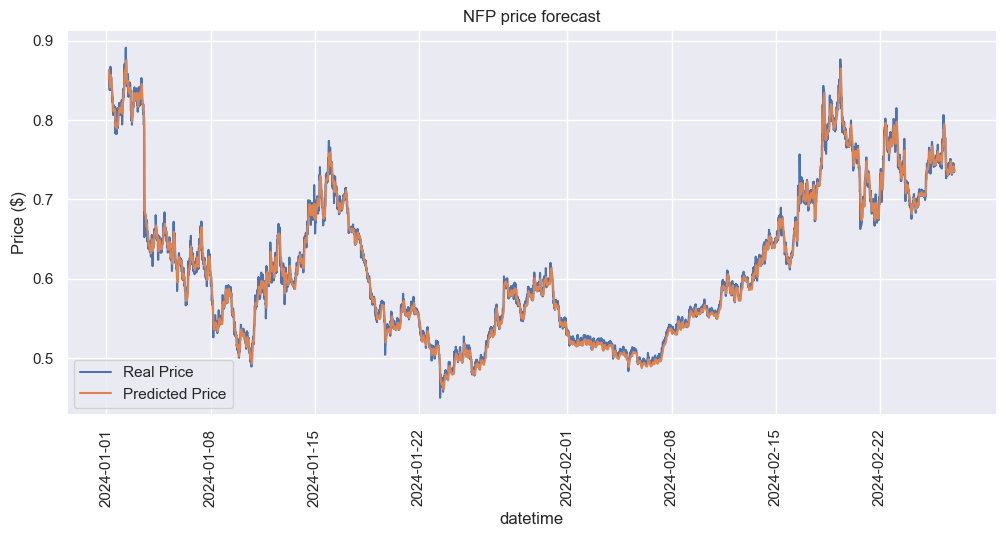

In [10]:
# Plot the results
plt.figure(figsize=(12, 5))
sns.lineplot(df_pred, x="datetime", y="real_price", label="Real Price")
sns.lineplot(df_pred, x="datetime", y="predicted_price", label="Predicted Price")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.title(f"{crypto} price forecast")
plt.show()

1/1 [==============================] - 0s 22ms/step


[]

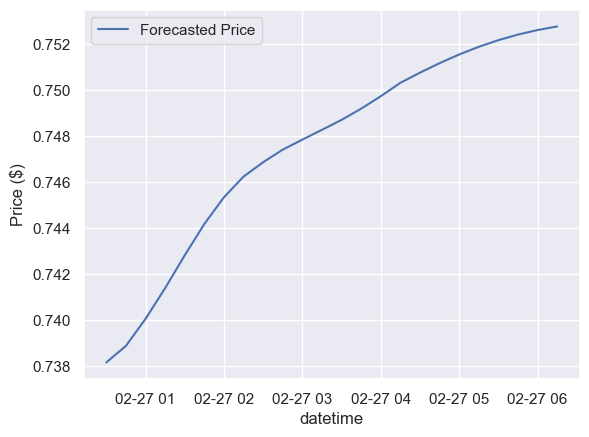

In [11]:
def forecast(data, futur):
    arr = np.expand_dims(data[-1], axis=0)
    #print(data.shape)
    #print(arr.shape)
    L = []
    for _ in range(futur):
        #print("[1]", arr.shape)
        prediction = model.predict(arr)
        #print("[2]", prediction.shape)
        prediction = prediction.reshape(1, 1, num_features)
        #print("[3]", prediction.shape)
        arr = np.append(arr, prediction, axis=1)
        #print("[4]", arr.shape)
        arr = np.delete(arr, 0, axis=1)
        #print("[5]", arr.shape)
        L.append(arr[0][-1])
    return np.array(L)


nb_time = 24
yForecast = forecast(X, nb_time)
yForecast = scaler.inverse_transform(yForecast)[:, 0]
xForecast = range(times[-1], times[-1] + nb_time)

timeDict = {
    "15m": "15T",
    "1h": "1H"
}

datetime = pd.date_range(start=df_pred["datetime"].values[-1], periods=nb_time + 1, freq=timeDict[timeframe])[1:]

forecast_dict = {"datetime": datetime, "timestamp": xForecast, "forecasted_price": yForecast}

df_forecast = pd.DataFrame.from_dict(forecast_dict)
df_forecast['datetime'] = pd.to_datetime(df_forecast['datetime'])

sns.lineplot(df_forecast, x="datetime", y="forecasted_price", label="Forecasted Price")
plt.ylabel("Price ($)")
plt.plot()

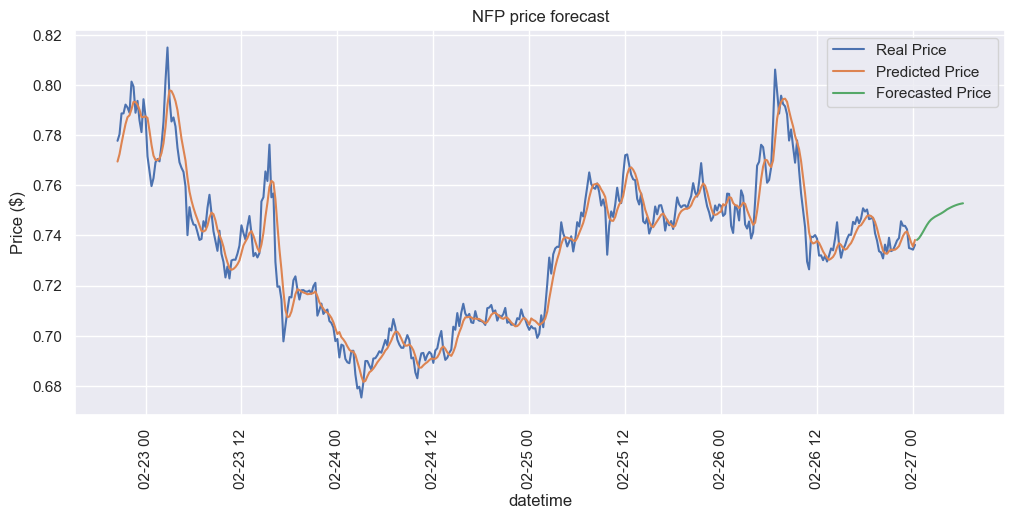

In [12]:
# Plot the results
plt.figure(figsize=(12, 5))
sns.lineplot(df_pred[-400:], x="datetime", y="real_price", label="Real Price")
sns.lineplot(df_pred[-400:], x="datetime", y="predicted_price", label="Predicted Price")
sns.lineplot(df_forecast, x="datetime", y="forecasted_price", label="Forecasted Price")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.title(f"{crypto} price forecast")
plt.show()